# 多重共线性判断与处理 Multicollinearity #

### 数据集 ### 
<b>1994年—2007年中国旅游收入及相关数据 </b>

<li>年份</li>
<li>国内旅游收入Y（亿元）</li>
<li>国内旅游人数X2（万人次）</li>
<li>城镇居民人均旅游花费X3（元）</li>
<li>农村居民人均旅游花费X4 （元）</li>
<li>公路里程 X5（万km）</li>
<li>铁路里程X6（万km）</li>

In [1]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
origin_data = pd.read_csv('multicollinearity_demo.csv',
                          skiprows=[0,1],
                          names=['year', 'income', 'people', 'consume_city', 'consume_country', 'miles_road', 'miles_rail'])

## 探究性分析 ##

### 绘制相关矩阵 ###

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000166FB279B00>,
      dtype=object)

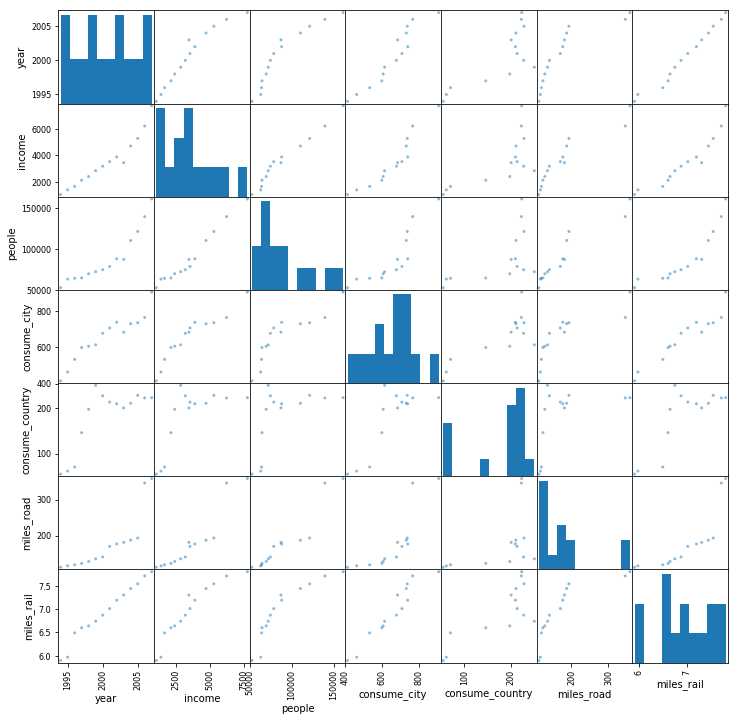

In [3]:
pd.plotting.scatter_matrix(origin_data, figsize=(12,12))

## STEPWISE 前向逐步分析法 ##

In [4]:
# 向前法
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            print('current formula: {}'.format(formula))
            
            # 可以用任何模型如glm, ols, wls等， 选择适合当前业务的
            aic = smf.ols(formula=formula, data=data).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('variable is {}, aic is {:.8}, continuing..\n'.format(selected, current_score))
        else:        
            print ('forward selection over!')
            break

    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    
    # 可以用任何模型如glm, ols, wls等， 选择适合当前业务的
    model = smf.ols(formula=formula, data=data).fit()
    
    # 对照模型，不使用STEPWISE
    model_contrast = smf.ols(formula='income ~ + year + people + consume_city + consume_country + miles_road + miles_rail', data=data).fit()
    
    return model, model_contrast

In [5]:
# 样本量必须大于等于20
# UserWarning: kurtosistest only valid for n>=20

data_for_select = origin_data
model_stepwise, model_contrast = forward_select(data=data_for_select, response='income')

current formula: income ~ year
current formula: income ~ people
current formula: income ~ miles_road
current formula: income ~ miles_rail
current formula: income ~ consume_city
current formula: income ~ consume_country
variable is ['people'], aic is 207.46237, continuing..

current formula: income ~ people + year
current formula: income ~ people + miles_road
current formula: income ~ people + miles_rail
current formula: income ~ people + consume_city
current formula: income ~ people + consume_country
variable is ['people', 'consume_city'], aic is 183.60138, continuing..

current formula: income ~ people + consume_city + year
current formula: income ~ people + consume_city + miles_road
current formula: income ~ people + consume_city + miles_rail
current formula: income ~ people + consume_city + consume_country
variable is ['people', 'consume_city', 'consume_country'], aic is 180.9929, continuing..

current formula: income ~ people + consume_city + consume_country + year
current formula:

In [6]:
# stepwise选择变量后的模型
model_stepwise.summary()

C:\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     740.4
Date:                Wed, 26 Sep 2018   Prob (F-statistic):           2.54e-11
Time:                        20:13:34   Log-Likelihood:                -84.647
No. Observations:                  14   AIC:                             179.3
Df Residuals:                       9   BIC:                             182.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1329.3487   1129.003     -1.177      0.269   -3883.330    1224.633
people              0.0461      0.003     15.630      0.000       0.039       0.053
consume_city        4.6031      1.051      4.382      0.002       2.227       6.979
consume_country     2.8112      1.089      2.582      0.030       0.348       5.274
miles_rail       -398.0537    241.255     -1.650      0.133    -943.810     147.703
==============================================================================
Omnibus:                        1.738   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                0.610
Skew:                           0.506   Prob(JB):                        0.737
Kurtosis:                       3.146   Cond. No.                     3.19e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# 对照模型
model_contrast.summary()

C:\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     499.2
Date:                Wed, 26 Sep 2018   Prob (F-statistic):           7.55e-09
Time:                        20:13:34   Log-Likelihood:                -82.814
No. Observations:                  14   AIC:                             179.6
Df Residuals:                       7   BIC:                             184.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.433e+05   1.37e+05     -1.046      0.330   -4.67e+05    1.81e+05
year               72.2889     69.814      1.035      0.335     -92.794     237.372
people              0.0396      0.005      7.373      0.000       0.027       0.052
consume_city        4.6225      1.074      4.303      0.004       2.082       7.163
consume_country     2.4638      1.175      2.096      0.074      -0.315       5.243
miles_road          1.5201      1.414      1.075      0.318      -1.824       4.864
miles_rail       -725.1420    432.678     -1.676      0.138   -1748.264     297.980
==============================================================================
Omnibus:                        0.231   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.091
Skew:                          -0.142   Prob(JB):                        0.955
Kurtosis:                       2.725   Cond. No.                     3.81e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 方差膨胀因子VIF ##
每个自变量（外生变量, X）与其他自变量做OLS，获得其他自变量对于该自变量的R^2，R^2越大，VIF增大，说明该自变量存在被（线性）替代的可能

### 分别对旅游人数people, 公路里程miles_road, 铁路里程miles_rail变量、STEPWISE选择后的变量计算其VIF膨胀因子 ###
参考 https://blog.csdn.net/songhao22/article/details/79369950

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_choosed = origin_data.loc[:,['people', 'miles_road', 'miles_rail']]
for i, name in enumerate(data_choosed.columns):
    vif = variance_inflation_factor(np.array(data_choosed), i)    # 针对第i列变量，计算其他变量对其的VIF，若过大则说明其他变量与其存在近似线性关系
    print( '{: <20}'.format(name + '"\'s VIF:'), '{:.6}'.format(vif))
    # '格式'.format(变量) 输出法，.6表示保留六位长度，<^>为左中右对齐，20为强制长度

people"'s VIF:       101.518
miles_road"'s VIF:   61.5821
miles_rail"'s VIF:   17.1813


In [9]:
data_stepwised = origin_data.loc[:,['people', 'consume_city', 'consume_country', 'miles_rail']]
for i, name in enumerate(data_stepwised.columns):
    vif = variance_inflation_factor(np.array(data_stepwised), i)    # 针对第i列变量，计算其他变量对其的VIF，若过大则说明其他变量与其存在近似线性关系
    print( '{: <20}'.format(name + '"\'s VIF:'), '{:.6}'.format(vif))
    # '格式'.format(变量) 输出法，.6表示保留六位长度，<^>为左中右对齐，20为强制长度

people"'s VIF:       38.4601
consume_city"'s VIF: 375.159
consume_country"'s VIF: 28.6278
miles_rail"'s VIF:   142.563


### 注：VIF较大只是存在多重共线性的必要条件而非充分条件。即，若出现多重共线性，则VIF大，VIF大并不一定能推出一定存在多重共线性，只作为参考和验证###

In [10]:
np.random.seed(64)
demo_x = np.random.rand(4,4)

# 对于numpy定义的行变量，需转置后，针对列变量进行VIF检验，若是DataFrame则不需要
vif = variance_inflation_factor(demo_x.T,1)

print("A Gauss Distribution Matrix's VIF:", vif)

A Gauss Distribution Matrix's VIF: 1152.0703477932182
